In [1]:
import matplotlib
from matplotlib import font_manager

!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv

fontpaths = ["C:/Users/kwon3/AppData/Local/Microsoft/Windows/Fonts/NanumGothicBold.ttf"]
font_files = font_manager.findSystemFonts(fontpaths=fontpaths)

for ff in font_files:
    font_manager.fontManager.addfont(ff)

matplotlib.rc('font', family="Malgun Gothic")
matplotlib.rcParams['axes.unicode_minus'] = False

'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.
'sudo'��(��) ���� �Ǵ� �ܺ� ����, ������ �� �ִ� ���α׷�, �Ǵ�
��ġ ������ �ƴմϴ�.


In [2]:
import pandas as pd
import numpy as np

DATA_PATH = "data/"

train_tr = pd.read_csv(f"{DATA_PATH}store_train_transactions.csv") # 학습용 구매기록 데이터
train_target = pd.read_csv(f"{DATA_PATH}store_train.csv") # 학습용 정답 데이터
test_tr = pd.read_csv(f"{DATA_PATH}store_test_transactions.csv") # 테스트용 구매기록 데이터
submit = pd.read_csv(f"{DATA_PATH}store_submission.csv") # 제출 양식 데이터

train_tr.shape , train_target.shape , test_tr.shape , submit.shape

((523105, 7), (14940, 2), (441196, 7), (12225, 2))

In [3]:
merged_data = pd.merge(train_tr, train_target, on="ID", how="left")
merged_data.head()

,ID,구매일시,지점코드,대분류,중분류,브랜드코드,구매가격,target
0,train_13219,2004-05-01 09:40:00,A144000,공산품파트,차류,5100,59700,0.0
1,train_5590,2004-05-01 09:40:00,A144000,잡화파트,화장잡화,5101,17000,0.0
2,train_7200,2004-05-01 10:20:00,A112000,공산품,용기보증,5100,34937,0.0
3,train_3010,2004-05-01 10:30:00,A373000,아동_스포츠,아동복,5105,19000,0.0
4,train_10851,2004-05-01 10:30:00,A112000,가정용품,전화기_카세트,5110,215000,0.0


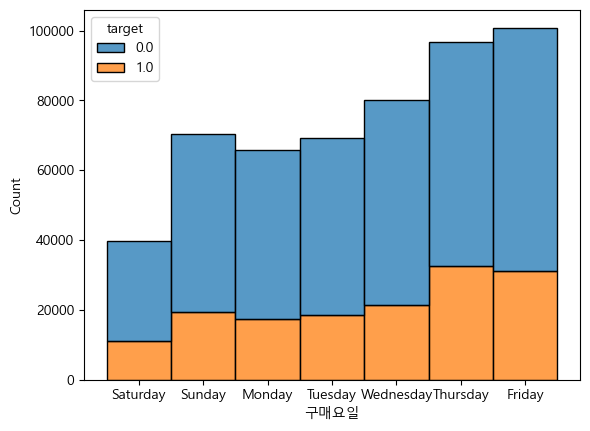

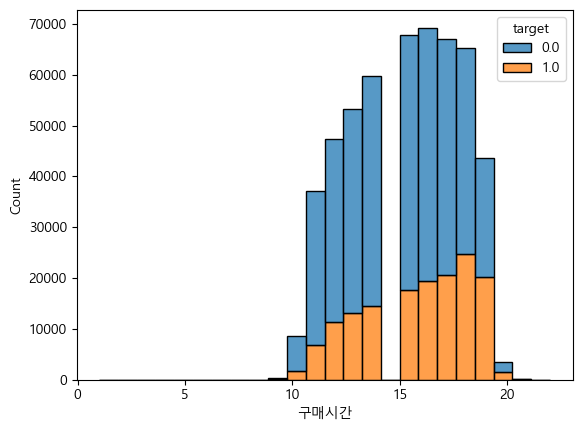

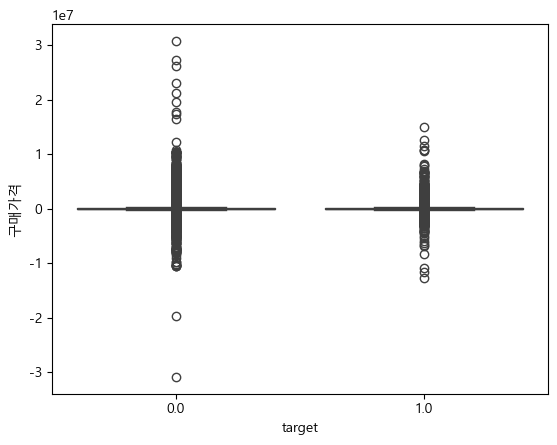

In [4]:
from matplotlib import axes
import matplotlib.pyplot as plt
import seaborn as sns

merged_data["구매일시"] = pd.to_datetime(merged_data["구매일시"])
merged_data["구매요일"] = merged_data["구매일시"].dt.day_name()
merged_data["구매시간"] = merged_data["구매일시"].dt.hour

sns.histplot(merged_data, x='구매요일', hue='target', multiple='stack', kde=False, bins=7)
plt.show()

sns.histplot(merged_data, x='구매시간', hue='target', multiple='stack', kde=False, bins=24)
plt.show()

sns.boxplot(merged_data, x="target", y="구매가격")
plt.show()

In [5]:
merged_data = pd.merge(train_target, train_tr, on='ID', how='left')

top_10_brands = merged_data['브랜드코드'].value_counts().nlargest(10).index

top_brands_data = merged_data[merged_data['브랜드코드'].isin(top_10_brands)]

purchase_rate_by_brand = top_brands_data.groupby(['브랜드코드', 'target']).size().unstack().fillna(0)

purchase_rate_by_brand['기혼 구매율'] = purchase_rate_by_brand[0] / purchase_rate_by_brand.sum(axis=1)
purchase_rate_by_brand['미혼 구매율'] = purchase_rate_by_brand[1] / purchase_rate_by_brand.sum(axis=1)

purchase_rate_by_brand = purchase_rate_by_brand[['기혼 구매율', '미혼 구매율']]
purchase_rate_by_brand

target,기혼 구매율,미혼 구매율
브랜드코드,,
5100,0.797679,0.202320
5111,0.569638,0.430313
5112,0.606245,0.393709
5116,0.655403,0.344557
5127,0.679458,0.320517
5128,0.691973,0.307972
5138,0.724086,0.275876
5149,0.601626,0.398320
5173,0.542581,0.457381


In [6]:
merged_data[merged_data["브랜드코드"] == 5240]['중분류'].unique()

array(['수입종합화장품', '영커리어캐주얼', '영트랜드', '캐릭터캐쥬얼', '영캐주얼', '용기보증'],
      dtype=object)

In [7]:
merged_data.groupby('ID')['브랜드코드'].agg(lambda x: (x == 5100).sum() / len(x))

ID
train_0       0.050000
train_1       0.142857
train_10      0.701493
train_100     0.076923
train_1000    0.000000
                ...   
train_9995    0.000000
train_9996    0.080000
train_9997    0.037037
train_9998    0.103448
train_9999    0.000000
Name: 브랜드코드, Length: 14940, dtype: float64

In [ ]:
# Filter data to include only rows where 대분류 is '잡화'
misc_data = merged_data[merged_data['대분류'] == '잡화']

# Group by 중분류 and target to count purchases for each marital status within 잡화
misc_purchase_counts = misc_data.groupby(['중분류', 'target']).size().unstack().fillna(0)

# Calculate the purchase rates (ratios) for married (target=0) customers within each 중분류
misc_purchase_counts['기혼 구매율'] = misc_purchase_counts[0] / misc_purchase_counts.sum(axis=1)
misc_purchase_counts['미혼 구매율'] = misc_purchase_counts[1] / misc_purchase_counts.sum(axis=1)

# Sort by '기혼 구매율' to find 중분류 categories with the highest rates for married customers
misc_purchase_counts_sorted = misc_purchase_counts.sort_values(by='기혼 구매율', ascending=False)[['기혼 구매율', '미혼 구매율']]
misc_purchase_counts_sorted

target,기혼 구매율,미혼 구매율
중분류,,
용기보증,1.000000,0.000000
지갑_벨트,0.772727,0.219561
가방,0.755319,0.242730
국산화장품,0.736187,0.263662
임대핸드백,0.732484,0.266274
보석,0.723776,0.275527
모자,0.720183,0.278895
행사핸드백,0.713725,0.285475
행사소품,0.707071,0.290852
